## **1.Introduction**  
Toronto is the provincial capital of Ontario and the most populous city in Canada. The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. More than 50 percent of residents belong to a visible minority population group, and over 200 distinct ethnic origins are represented among its inhabitants. While the majority of Torontonians speak English as their primary language, over 160 languages are spoken in the city.
Such a diverse city would be the best place to open a Multi-cuisine restaurant.

## **1.1 Business Problem**  
The objective of this capstone project is to analyze and recommend the best neighborhoods in the city of Toronto to open a new Multi-cuisine restaurant serving different continental foods. Using data science methodology and machine learning techniques like clustering, this project aims to provide solutions to answer the business question: Where would you recommend a new investor to open a Multi-cuisine restaurant in the city of Toronto?

In this project we would be mainly looking at:  
1. Areas for large scope of shopping-  Because common most people shop at least once every week and that is usually the same day they decide to dine out!
2. Areas having restaurant venues- So that we can perform clustering on them and accordingly check for the concentration of restaurants in these areas.

## **2.1 Data Required**  
To solve the problem, we will need the following data:
1. List of neighborhoods in Toronto. 
2. Latitude and longitude coordinates of those neighborhoods. This is required in order to plot the map and also to get the venue data.
3. Venue data, particularly data related to areas with restaurants and shopping places.We get this using Foursquare API

## Importing all libraries

In [1]:
import requests 
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.pyplot as plt

get_ipython().system(u' pip install beautifulsoup4')
from bs4 import BeautifulSoup
from urllib.request import urlopen
import re
!conda install -c anaconda xlrd --yes
print('Required libraries are imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.2

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    numpy-1.18.1               |   py36h95a1406_0         5.2 MB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    sci

## Scrap data from Wikipedia page into a DataFrame using Beautifulsoup

In [2]:
#web parser
page = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(page.content, 'html.parser')

In [3]:
table = soup.find('tbody')
rows = table.select('tr')
row = [r.get_text() for r in rows]

## Creating Dataframe

In [4]:
#creating df
df = pd.DataFrame(row)
df.head()

,0
0,\nPostcode\nBorough\nNeighbourhood\n
1,\nM1A\nNot assigned\nNot assigned\n
2,\nM2A\nNot assigned\nNot assigned\n
3,\nM3A\nNorth York\nParkwoods\n
4,\nM4A\nNorth York\nVictoria Village\n


## Cleaning Data and assigning column names

In [5]:
#cleaning data
df1 = df[0].str.split('\n', expand=True)
df1.head()

,0,1,2,3,4
0,,Postcode,Borough,Neighbourhood,
1,,M1A,Not assigned,Not assigned,
2,,M2A,Not assigned,Not assigned,
3,,M3A,North York,Parkwoods,
4,,M4A,North York,Victoria Village,


In [6]:
df2 = df1.rename(columns=df1.iloc[0])
df3 = df2.drop(df2.index[0])
df3.head()

,,Postcode,Borough,Neighbourhood,
1,,M1A,Not assigned,Not assigned,
2,,M2A,Not assigned,Not assigned,
3,,M3A,North York,Parkwoods,
4,,M4A,North York,Victoria Village,
5,,M5A,Downtown Toronto,Harbourfront,


In [7]:
df3.rename(columns = {'Postcode':'PostalCode'}, inplace = True) 
df3.rename(columns = {'Neighbourhood':'Neighborhood'}, inplace = True) 
df3.head()

,,PostalCode,Borough,Neighborhood,
1,,M1A,Not assigned,Not assigned,
2,,M2A,Not assigned,Not assigned,
3,,M3A,North York,Parkwoods,
4,,M4A,North York,Victoria Village,
5,,M5A,Downtown Toronto,Harbourfront,


## Ignored rows with boroughs that is "not assigned"

In [8]:
#ignoring 'not assigned' rows
df4 = df3[df3.Borough != 'Not assigned']
df4.head()

,,PostalCode,Borough,Neighborhood,
3,,M3A,North York,Parkwoods,
4,,M4A,North York,Victoria Village,
5,,M5A,Downtown Toronto,Harbourfront,
6,,M6A,North York,Lawrence Heights,
7,,M6A,North York,Lawrence Manor,


## Group neighborhoods in the same borough

In [9]:
#groupby postalcode and Borough
df5= df4.groupby(['PostalCode' , 'Borough'], sort = False).agg(','.join)
df5.reset_index(inplace = True)
df5.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Queen's Park,Not assigned
6,M1B,Scarborough,"Rouge,Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens,Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson,Garden District"


## For Neighborhood="Not assigned", make the value the same as Borough

In [10]:
# for Neighborhood="Not assigned", make the value the same as Borough
for index, row in df5.iterrows():
    if row["Neighborhood"] == "Not assigned":
        row["Neighborhood"] = row["Borough"]
        
df5.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights,Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park
5,M9A,Queen's Park,Queen's Park
6,M1B,Scarborough,"Rouge,Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens,Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson,Garden District"


## Used .shape to print number of rows and columns

In [11]:
df5.shape

(103, 3)

## Load coordinates from csv file

In [12]:
## get all geographical coordinates of the neighborhoods.
coordinates = pd.read_csv('https://cocl.us/Geospatial_data')
coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [13]:
# rename the column "PostalCode"
coordinates.rename(columns={"Postal Code": "PostalCode"}, inplace=True)
coordinates.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Merging the two tables

In [14]:
# merge two table on the column "PostalCode"
df5 = df5.merge(coordinates, on="PostalCode", how="left")
df5.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Downtown Toronto,Queen's Park,43.662301,-79.389494


## Use geopy library to get the latitude and longitude values of Toronto

In [15]:
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


## Create a map of Toronto with neighborhoods superimposed on top

In [16]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df5['Latitude'], df5['Longitude'], df5['Borough'], df5['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto

In [76]:
# save the map as HTML file
map_clusters.save('Toronto_map.html')

## For simplicity let us look at Boroughs with names that contain word 'Toronto'

In [17]:
# filter borough names that contain the word Toronto
borough_names = list(df5.Borough.unique())

borough_with_toronto = []

for x in borough_names:
    if "toronto" in x.lower():
        borough_with_toronto.append(x)
        
borough_with_toronto

['Downtown Toronto', 'East Toronto', 'West Toronto', 'Central Toronto']

In [18]:
# create a new DataFrame with only boroughs that contain the word Toronto
df6= df5[df5['Borough'].isin(borough_with_toronto)].reset_index(drop=True)
df6.shape

(39, 5)

## Visualize boroughs having 'Toronto'

In [19]:
map_toronto1 = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df6['Latitude'], df6['Longitude'], df6['Borough'], df6['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto1)  
    
map_toronto1

In [75]:
# save the map as HTML file
map_clusters.save('Toronto_boroughs.html')

## Use the Foursquare API to explore the neighborhoods

In [20]:
# define Foursquare Credentials and Version
CLIENT_ID = 'BRFKUNQD0BWTEPLDZGFJ4VM3KWDQMCNS05A5TVRJC0CF1TI2' # your Foursquare ID
CLIENT_SECRET = '2JLWIJJ1PQ0WSWVLYEMSAFNKTEG5RBVJDHX5OCNPUGWWTIQJ' # your Foursquare Secret
VERSION = '20190822' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: BRFKUNQD0BWTEPLDZGFJ4VM3KWDQMCNS05A5TVRJC0CF1TI2
CLIENT_SECRET:2JLWIJJ1PQ0WSWVLYEMSAFNKTEG5RBVJDHX5OCNPUGWWTIQJ


## Getting the top 100 venues that are within a radius of 500 meters

In [21]:
radius = 500
LIMIT = 100

venues = []

for lat, long, post, borough, neighborhood in zip(df6['Latitude'], df6['Longitude'], df6['PostalCode'], df6['Borough'], df6['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            post, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [22]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['PostalCode', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1717, 9)


,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


## Venues were returned for each PostalCode

In [23]:
venues_df.groupby(["PostalCode", "Borough", "Neighborhood"]).count()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
PostalCode,Borough,Neighborhood,,,,,,
M4E,East Toronto,The Beaches,7,7,7,7,7,7
M4K,East Toronto,"The Danforth West,Riverdale",41,41,41,41,41,41
M4L,East Toronto,"The Beaches West,India Bazaar",19,19,19,19,19,19
M4M,East Toronto,Studio District,42,42,42,42,42,42
M4N,Central Toronto,Lawrence Park,3,3,3,3,3,3
M4P,Central Toronto,Davisville North,8,8,8,8,8,8
M4R,Central Toronto,North Toronto West,20,20,20,20,20,20
M4S,Central Toronto,Davisville,38,38,38,38,38,38
M4T,Central Toronto,"Moore Park,Summerhill East",2,2,2,2,2,2


## Number of unique categories that can be curated from all the returned venues

In [24]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 234 uniques categories.


In [25]:
venues_df.head()

,PostalCode,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,Downtown Toronto,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


## Analyze each neighborhood

In [50]:
# one hot encoding
toronto_onehotEn = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")
# add postal, borough and neighborhood column back to dataframe
toronto_onehotEn['PostalCode'] = venues_df['PostalCode'] 
toronto_onehotEn['Borough'] = venues_df['Borough'] 
toronto_onehotEn['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(toronto_onehotEn.columns[-3:]) + list(toronto_onehotEn.columns[:-3])
toronto_onehotEn = toronto_onehotEn[fixed_columns]

print(toronto_onehotEn.shape)
toronto_onehotEn.head()

(1717, 237)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M5A,Downtown Toronto,Harbourfront,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,Downtown Toronto,Harbourfront,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,Harbourfront,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,Downtown Toronto,Harbourfront,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,Downtown Toronto,Harbourfront,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Analyzing neighbourhoods with largest number of shopping areas

In [29]:
toronto_shopping = toronto_onehotEn[['Neighborhoods','Antique Shop','Arts & Crafts Store','Bookstore','Comic Shop', 'Boutique', 'Market', 'Record Shop','Shoe Store','Shopping Mall','Sporting Goods Shop', 'Stationery Store', 'Supermarket','Thrift / Vintage Store','Toy / Game Store','Video Game Store',"Women's Store"]]
toronto_shopping_group = toronto_shopping.groupby('Neighborhoods').sum(ascending=False)
toronto_shopping_group['Total'] =  toronto_shopping_group.sum (axis = 1)
toronto_shopping_group.sort_values("Total",ascending=False,axis=0,inplace=True)
toronto_shopping_group.head(5)

,Antique Shop,Arts & Crafts Store,Bookstore,Comic Shop,Boutique,Market,Record Shop,Shoe Store,Shopping Mall,Sporting Goods Shop,Stationery Store,Supermarket,Thrift / Vintage Store,Toy / Game Store,Video Game Store,Women's Store,Total
Neighborhoods,,,,,,,,,,,,,,,,,
"Ryerson,Garden District",0,0,2,1,0,0,0,1,1,1,0,0,0,1,1,0,8
"Design Exchange,Toronto Dominion Centre",0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,4
Stn A PO Boxes 25 The Esplanade,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,4
"Adelaide,King,Richmond",0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,3
Studio District,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,3


## Plotting a pie chart of the top 8 largest shopping neighborhoods for better visualization

In [32]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.1


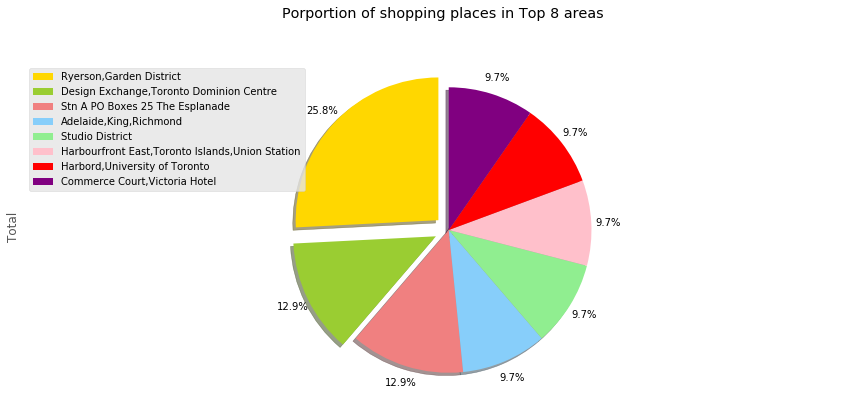

In [34]:
top_8_neighborhood = toronto_shopping_group.head(8)
colors_list = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink','red', 'purple']
explode_list = [0.1, 0.1, 0, 0, 0, 0,0, 0] # ratio for each continent with which to offset each wedge.

top_8_neighborhood['Total'].plot(kind='pie',
                            figsize=(15, 6),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            explode=explode_list # 'explode' lowest 3 continents
                            )

# scale the title up by 12% to match pctdistance
plt.title('Porportion of shopping places in Top 8 areas', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=top_8_neighborhood.index, loc='upper left') 

plt.show()

# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [35]:
group_df = toronto_onehotEn.groupby(["PostalCode", "Borough", "Neighborhoods"]).mean().reset_index()

print(group_df.shape)
group_df

(39, 237)


,PostalCode,Borough,Neighborhoods,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,M4E,East Toronto,The Beaches,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.142857,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
1,M4K,East Toronto,"The Danforth West,Riverdale",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024390,...,0.000000,0.024390,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.024390
2,M4L,East Toronto,"The Beaches West,India Bazaar",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
3,M4M,East Toronto,Studio District,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.023810,0.000000,0.00,0.023810
4,M4N,Central Toronto,Lawrence Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
5,M4P,Central Toronto,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
6,M4R,Central Toronto,North Toronto West,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.050000
7,M4S,Central Toronto,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.026316,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
8,M4T,Central Toronto,"Moore Park,Summerhill East",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000
9,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,...,0.000000,0.000000,0.00,0.000000,0.000000,0.066667,0.000000,0.000000,0.00,0.000000


## Dataframe for restaurants

In [36]:
tor_restaurant = group_df[["Neighborhoods","Restaurant"]]

In [61]:
tor_restaurant.head(10)

,Neighborhoods,Restaurant
0,The Beaches,0.000000
1,"The Danforth West,Riverdale",0.024390
2,"The Beaches West,India Bazaar",0.000000
3,Studio District,0.000000
4,Lawrence Park,0.000000
5,Davisville North,0.000000
6,North Toronto West,0.050000
7,Davisville,0.026316
8,"Moore Park,Summerhill East",0.000000
9,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",0.066667


## Running Kmeans to cluster the neighborhoods

In [42]:
# set number of clusters
kclusters = 3

k_clustering = tor_restaurant.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(k_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 2, 0, 0, 0, 0, 1, 2, 0, 1], dtype=int32)

In [43]:
# Create a new dataframe that includes the cluster label
k_merged = tor_restaurant.copy()

# add clustering labels
k_merged["Cluster Labels"] = kmeans.labels_

In [58]:
k_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
# Merge with the neighborhood datframe to get latitude/longitude for each neighborhood
k_merged = k_merged.join(df5.set_index("Neighborhood"), on="Neighborhood")
k_merged.head(5)

,Neighborhood,Restaurant,Cluster Labels,PostalCode,Borough,Latitude,Longitude
0,The Beaches,0.00000,0,M4E,East Toronto,43.676357,-79.293031
1,"The Danforth West,Riverdale",0.02439,2,M4K,East Toronto,43.679557,-79.352188
2,"The Beaches West,India Bazaar",0.00000,0,M4L,East Toronto,43.668999,-79.315572
3,Studio District,0.00000,0,M4M,East Toronto,43.659526,-79.340923
4,Lawrence Park,0.00000,0,M4N,Central Toronto,43.728020,-79.388790


In [60]:
k_merged.head(50)

,Neighborhood,Restaurant,Cluster Labels,PostalCode,Borough,Latitude,Longitude
0,The Beaches,0.000000,0,M4E,East Toronto,43.676357,-79.293031
1,"The Danforth West,Riverdale",0.024390,2,M4K,East Toronto,43.679557,-79.352188
2,"The Beaches West,India Bazaar",0.000000,0,M4L,East Toronto,43.668999,-79.315572
3,Studio District,0.000000,0,M4M,East Toronto,43.659526,-79.340923
4,Lawrence Park,0.000000,0,M4N,Central Toronto,43.728020,-79.388790
5,Davisville North,0.000000,0,M4P,Central Toronto,43.712751,-79.390197
6,North Toronto West,0.050000,1,M4R,Central Toronto,43.715383,-79.405678
7,Davisville,0.026316,2,M4S,Central Toronto,43.704324,-79.388790
8,"Moore Park,Summerhill East",0.000000,0,M4T,Central Toronto,43.689574,-79.383160
9,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",0.066667,1,M4V,Central Toronto,43.686412,-79.400049


## Visualize the clusters

In [62]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(k_merged['Latitude'], k_merged['Longitude'], k_merged['Neighborhood'], k_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [63]:
# save the map as HTML file
map_clusters.save('Toronto_neighborhood_restaurant_clusters.html')

## Check the clusters

### Cluster 0

In [64]:
k_merged.loc[k_merged['Cluster Labels'] == 0]

,Neighborhood,Restaurant,Cluster Labels,PostalCode,Borough,Latitude,Longitude
0,The Beaches,0.0,0,M4E,East Toronto,43.676357,-79.293031
2,"The Beaches West,India Bazaar",0.0,0,M4L,East Toronto,43.668999,-79.315572
3,Studio District,0.0,0,M4M,East Toronto,43.659526,-79.340923
4,Lawrence Park,0.0,0,M4N,Central Toronto,43.728020,-79.388790
5,Davisville North,0.0,0,M4P,Central Toronto,43.712751,-79.390197
8,"Moore Park,Summerhill East",0.0,0,M4T,Central Toronto,43.689574,-79.383160
10,Rosedale,0.0,0,M4W,Downtown Toronto,43.679563,-79.377529
17,Central Bay Street,0.0,0,M5G,Downtown Toronto,43.657952,-79.387383
22,Roselawn,0.0,0,M5N,Central Toronto,43.711695,-79.416936
23,"Forest Hill North,Forest Hill West",0.0,0,M5P,Central Toronto,43.696948,-79.411307


### Cluster 1

In [65]:
k_merged.loc[k_merged['Cluster Labels'] == 1]

,Neighborhood,Restaurant,Cluster Labels,PostalCode,Borough,Latitude,Longitude
6,North Toronto West,0.050000,1,M4R,Central Toronto,43.715383,-79.405678
9,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",0.066667,1,M4V,Central Toronto,43.686412,-79.400049
11,"Cabbagetown,St. James Town",0.066667,1,M4X,Downtown Toronto,43.667967,-79.367675
13,Harbourfront,0.042553,1,M5A,Downtown Toronto,43.654260,-79.360636
15,St. James Town,0.050000,1,M5C,Downtown Toronto,43.651494,-79.375418
20,"Design Exchange,Toronto Dominion Centre",0.050000,1,M5K,Downtown Toronto,43.647177,-79.381576
21,"Commerce Court,Victoria Hotel",0.050000,1,M5L,Downtown Toronto,43.648198,-79.379817
25,"Harbord,University of Toronto",0.057143,1,M5S,Downtown Toronto,43.662696,-79.400049
30,Christie,0.055556,1,M6G,Downtown Toronto,43.669542,-79.422564
32,"Little Portugal,Trinity",0.056604,1,M6J,West Toronto,43.647927,-79.419750


### Cluster 2

In [66]:
k_merged.loc[k_merged['Cluster Labels'] == 2]

,Neighborhood,Restaurant,Cluster Labels,PostalCode,Borough,Latitude,Longitude
1,"The Danforth West,Riverdale",0.024390,2,M4K,East Toronto,43.679557,-79.352188
7,Davisville,0.026316,2,M4S,Central Toronto,43.704324,-79.388790
12,Church and Wellesley,0.037037,2,M4Y,Downtown Toronto,43.665860,-79.383160
14,"Ryerson,Garden District",0.020000,2,M5B,Downtown Toronto,43.657162,-79.378937
16,Berczy Park,0.017857,2,M5E,Downtown Toronto,43.644771,-79.373306
18,"Adelaide,King,Richmond",0.030000,2,M5H,Downtown Toronto,43.650571,-79.384568
19,"Harbourfront East,Toronto Islands,Union Station",0.030000,2,M5J,Downtown Toronto,43.640816,-79.381752
28,Stn A PO Boxes 25 The Esplanade,0.031915,2,M5W,Downtown Toronto,43.646435,-79.374846
29,"First Canadian Place,Underground city",0.040000,2,M5X,Downtown Toronto,43.648429,-79.382280
36,"Runnymede,Swansea",0.025000,2,M6S,West Toronto,43.651571,-79.484450


## Viewing Top eight neighborhoods with largest number of shopping places 

In [67]:
top_8_neighborhood = toronto_shopping_group.head(8)
top_8_neighborhood

,Antique Shop,Arts & Crafts Store,Bookstore,Comic Shop,Boutique,Market,Record Shop,Shoe Store,Shopping Mall,Sporting Goods Shop,Stationery Store,Supermarket,Thrift / Vintage Store,Toy / Game Store,Video Game Store,Women's Store,Total
Neighborhoods,,,,,,,,,,,,,,,,,
"Ryerson,Garden District",0,0,2,1,0,0,0,1,1,1,0,0,0,1,1,0,8
"Design Exchange,Toronto Dominion Centre",0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,4
Stn A PO Boxes 25 The Esplanade,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,4
"Adelaide,King,Richmond",0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,3
Studio District,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,3
"Harbourfront East,Toronto Islands,Union Station",0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,3
"Harbord,University of Toronto",0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,3
"Commerce Court,Victoria Hotel",0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,3


## Observations & Results

The results from the k-means clustering shows that we can categorize the neighbourhoods into 3 clusters based on the frequency of occurrence of Restaurants:  

 Cluster 0: Neighbourhoods with low concentration of Restaurants    
 Cluster 1: Neighbourhoods with High concentration of Restaurants  
 Cluster 2: Neighbourhoods with medium concentration of Restaurants  

Also according to our pie chart the neighborhoods: (Ryerson,Garden District) , (Adelaide,King,Richmond) and (Harbourfront East,Toronto Islands,Union Station) all come under the top 8 largest shopping neighborhoods and these three also fall under cluster 2)  

The neighborhoods: (Design Exchange,Toronto Dominion Centre),(Commerce Court,Victoria Hotel) and (Harbord,University of Toronto) are also under the top 8 largest shopping neighborhoods and belong to cluster 1

## Discussion

Cluster 0 has low concentration of restaurants meaning it might not be a good place for profitable restaurants.    
Cluster 1 has high concentration of restaurants which means competition will be very high.    
Cluster 2 has a medium concentration so it would be ideal for restaurants.  

Also families spent their weekdays and especially weekends shopping and that is also usually the same day they dine out! So we should look for neighborhoods with lot of shopping possibilities.  

As per our observation the top 3 ideal neighborhoods to start a multicuisine restaurant would be (Ryerson,Garden District) , (Adelaide,King,Richmond) and (Harbourfront East,Toronto Islands,Union Station) as they are one of the top largest shopping neighborhood and also fall under cluster 2.  

## Conclusion

To start a multicuisine restaurant we should consider the neighborhoods  (Ryerson,Garden District) , (Adelaide,King,Richmond) and (Harbourfront East,Toronto Islands,Union Station). The final decision will depend on in depth analysis of these 3 neighborhoods as well as many other factors such as financing, operational agreements & business-related terms and conditions agreed upon by all the stakeholders involved.